# Support Vector Machine for Trading

**Background:**

Suppose you are working as an analyst at an investment bank. Your manager asked you to implement a new trading algorithm for Microsoft stock.

You decided to use the following indicators:

* Average True Range
* Commodity Channel Index
* Relative Strength Index
* Bollinger Bands
* On Balance Volume
* Momentum
* MACD


Your training set includes data up to 03/18/2022. You will apply time series cross-validation to tune the hyper-parameter. Test the model on the last 30 trading days.

**Objective**
* Use SVM Classification on financial data
* Use Randomized Search
* Use Time Series Cross Validation
* Evaluate trading model

In [2]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3977    0  3977    0     0  51649      0 --:--:-- --:--:-- --:--:-- 51649
100  503k  100  503k    0     0  2606k      0 --:--:-- --:--:-- --:--:-- 9454k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4017    0  4017    0     0  52168      0 --:--:-- --:--:-- --:--:-- 52168
100  406k  100  406k    0     0  2174k      0 --:--:-- --:--:-- --:--:-- 2174k


In [3]:
! pip install yfinance

     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 6.4 MB 47.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import yfinance as yf
import talib as ta
from talib import MA_Type  
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit as tscv

In [5]:
msft=yf.Ticker('msft')
df=msft.history('max')

In [6]:
df.tail(30)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-21,298.890015,300.140015,294.899994,299.160004,28351200,0.0,0.0
2022-03-22,299.799988,305.000000,298.769989,304.059998,27599700,0.0,0.0
2022-03-23,300.510010,303.230011,297.720001,299.489990,25715400,0.0,0.0
2022-03-24,299.140015,304.200012,298.320007,304.100006,24484500,0.0,0.0
2022-03-25,305.230011,305.500000,299.290009,303.679993,22566500,0.0,0.0
2022-03-28,304.329987,310.799988,304.329987,310.700012,29578200,0.0,0.0
2022-03-29,313.910004,315.820007,309.049988,315.410004,30393400,0.0,0.0
2022-03-30,313.760010,315.950012,311.579987,313.859985,28163600,0.0,0.0
2022-03-31,313.899994,315.140015,307.890015,308.309998,33422100,0.0,0.0


In [7]:
help(ta.CCI)

Help on function CCI in module talib._ta_lib:

CCI(...)
    CCI(high, low, close[, timeperiod=?])
    
    Commodity Channel Index (Momentum Indicators)
    
    Inputs:
        prices: ['high', 'low', 'close']
    Parameters:
        timeperiod: 14
    Outputs:
        real



In [8]:
df['High Shifted'] = df['High'].shift(1)
df['Low Shifted'] = df['Low'].shift(1)
df['Close Shifted'] = df['Close'].shift(1)
df['Upper BBand'], df['Middle BBand'], df['Lower BBand']= ta.BBANDS(df['Close Shifted'],timeperiod=20)
df['RSI'] = ta.RSI(np.array(df['Close Shifted']), timeperiod=14)
df['Macd'], df['Macd Signal'],df['Macd Hist'] = ta.MACD(df['Close Shifted'], fastperiod=12, slowperiod=26, signalperiod=9)
df['Momentum'] = ta.MOM(df['Close Shifted'],timeperiod=12)
df['OBV'] = ta.OBV(df['Close Shifted'],df['Volume'].shift(1))
df['ATR'] = ta.ATR(df['High'].shift(1),df['Low'].shift(1),df['Close'].shift(1))
df['Returns'] = np.log(df['Open']/df['Open'].shift(1))
df['CCI']=ta.CCI(df['High Shifted'],df['Low Shifted'],df['Close Shifted'])
df['Signal'] =np.where(df.Returns >= 0, 1, 0)

df.dropna(inplace=True)

X = df.drop(['Signal','Returns','Open','Close','Volume','High','Low','Dividends','Stock Splits'],1)
Y = df['Signal']


In [ ]:
from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler()

In [ ]:
X_train = minmax.fit_transform(X.iloc[:-30,:])
X_test = pd.DataFrame(minmax.transform(X)).iloc[-30:,:]
y_train = Y.iloc[:-30]
y_test = Y.iloc[-30:]

In [ ]:
# Takes approx 6 mins
# Call the classifier:
clf = SVC(kernel='rbf')
# Parameter Grid
param_grid={'C':[1,10,100,1000]}
# Randomized Search over Space and Fit:
clf_search = RandomizedSearchCV(clf, param_distributions=param_grid, cv = tscv(5,test_size=1, gap=0))
clf_search.fit(X_train,y_train)
# Predict
y_pred=clf_search.predict(X_test)

In [ ]:
from sklearn import metrics
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)

In [ ]:
print(Accuracy)
print(Precision)
print(Recall)

0.6
0.6666666666666666
0.5


In [ ]:
df['SVM Signal'] = 0
df['SVM Returns'] = 0
df['Total Strat Returns'] = 0
df['Market Returns'] = 0    

In [ ]:
Signal_Column = df.columns.get_loc('SVM Signal')
Strat_Column = df.columns.get_loc('SVM Returns')
Return_Column = df.columns.get_loc('Total Strat Returns')
Market_Column = df.columns.get_loc('Market Returns')
     
df.iloc[-30:,Signal_Column] = list(map(int,y_pred))
df['SVM Returns'] = df['SVM Signal'] * df['Returns'].shift(-1)
    
df.iloc[-30:,Return_Column] = np.nancumsum(df['SVM Returns'][-30:])
df.iloc[-30:,Market_Column] = np.nancumsum(df['Returns'][-30:])
    
df['Sharpe_Ratio'] = (df['Total Strat Returns'][-1] - df['Market Returns'][-1])/np.nanstd(df['Total Strat Returns'][-30:])

In [ ]:
df['Sharpe_Ratio']

Date
1986-05-01    5.278515
1986-05-02    5.278515
1986-05-05    5.278515
1986-05-06    5.278515
1986-05-07    5.278515
                ...   
2022-04-25    5.278515
2022-04-26    5.278515
2022-04-27    5.278515
2022-04-28    5.278515
2022-04-29    5.278515
Name: Sharpe_Ratio, Length: 9074, dtype: float64

In [ ]:
print(Accuracy)
print(Precision)
print(Recall)

0.6
0.7272727272727273
0.47058823529411764


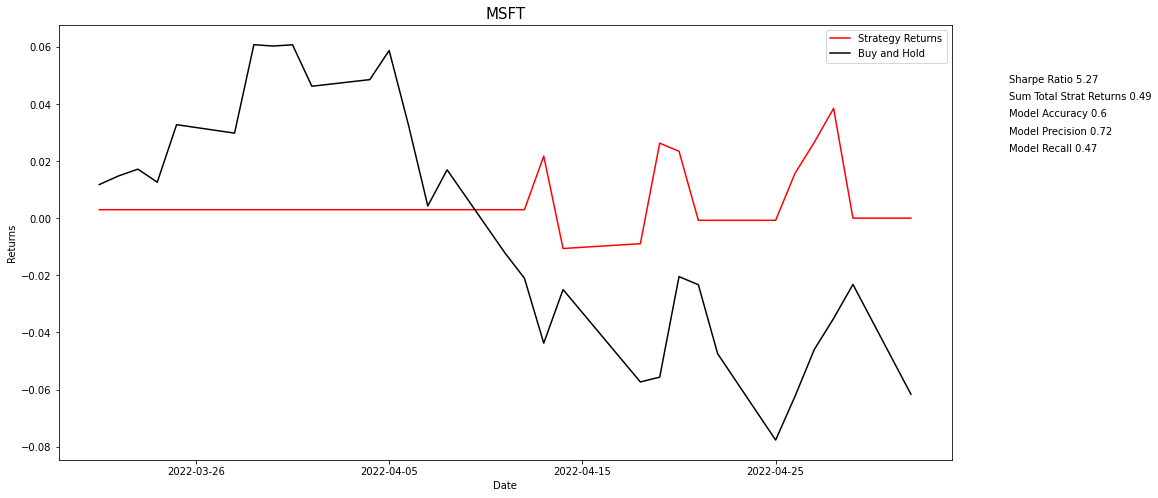

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16, 8
                                ))

ax.plot(df[-30:].index.values, df['Total Strat Returns'][-30:].values, color='r', label="Strategy Returns")
ax.plot(df[-30:].index.values, df['Market Returns'][-30:].values, color='k', label="Buy and Hold")
    
ax.set(xlabel= "Date",ylabel="Returns")
plt.title('MSFT',fontsize=15)
ax.xaxis.set_major_locator(ticker.AutoLocator())
    
plt.figtext(.95,0.78, s="Sharpe Ratio "+'5.27')
plt.figtext(.95,0.75, s="Sum Total Strat Returns "+'0.49')
plt.figtext(.95,0.72,s="Model Accuracy " +'0.6')
plt.figtext(.95,0.69,s="Model Precision " +'0.72')
plt.figtext(.95,0.66,s="Model Recall " +'0.47')
    
plt.legend(loc='best')
plt.show()